In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn import linear_model
from tqdm import tqdm 
import os 

In [2]:
# Constants and conversion coefficients
ELECTRON_CHARGE = 1.60217662E-19 
DALTON = 1.66053906660E-27
ANGSTROM = 1.0E-10

FREQ_UNIT = np.sqrt(ELECTRON_CHARGE / DALTON) / ANGSTROM
FREQ_UNIT_THZ = FREQ_UNIT / 1.0E12 / (2.0 * np.pi)
print('One frequency units in THz: ', FREQ_UNIT_THZ)

OMEGA_LOW_HZ = 5.308E12
OMEGA_LOW = 2.0 * np.pi * OMEGA_LOW_HZ / FREQ_UNIT

TIME_UNIT = ANGSTROM / np.sqrt(ELECTRON_CHARGE / DALTON)
TIME_UNIT_FS = TIME_UNIT / 1.0E-15
print('One time units in fs:', TIME_UNIT_FS)

One frequency units in THz:  15.633304171553409
One time units in fs: 10.180505755238615


In [3]:
def readPES(filename='energy.txt'):
    """
    Read PES obtained by DFT calculations from file 
    """
    qLowList = []
    qHighList = []
    potentialList = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            if line[0] == '#': continue
            line = list(map(float, line.strip('\n').split()))
            qLowList.append(line[0])
            qHighList.append(line[1])
            potentialList.append(line[2])
    qLowList = np.asarray(qLowList)
    qHighList = np.asarray(qHighList)
    potentialList  = np.asarray(potentialList)
    potentialList -= min(potentialList)
    return qLowList, qHighList, potentialList 


def getLinePESQHighConst(qLow, qHigh, potential, qHighConst):
    """
    Obtain line with Q_high = const from PES
    """
    qLowLine = []
    qHighLine = []
    potLine = []
    for ql, qh, pot in zip(qLow, qHigh, potential):
        if np.abs(qh - qHighConst) < 1E-10:
            qLowLine.append(ql)
            qHighLine.append(qh)
            potLine.append(pot)
    return np.asarray(qLowLine), np.asarray(qHighLine), np.asarray(potLine)


def getLinePESQLowConst(qLow, qHigh, potential, qLowConst):
    """
    Obtain line with Q_high = const from PES
    """
    qLowLine = []
    qHighLine = []
    potLine = []
    for ql, qh, pot in zip(qLow, qHigh, potential):
        if np.abs(ql - qLowConst) < 1E-8:
            qLowLine.append(ql)
            qHighLine.append(qh)
            potLine.append(pot)
    return np.asarray(qLowLine), np.asarray(qHighLine), np.asarray(potLine)

In [8]:
pesDir = "C:\\Users\\p.zhilyaev\\Desktop\\Brekhov\\BTO\\PES"
os.chdir(pesDir)
qLow, qHigh, pot = readPES(filename='BTO.PES')
pot -= min(pot)
print(min(qLow), max(qLow))
print(min(qHigh), max(qHigh))

-3.0 3.0
-1.5 1.5


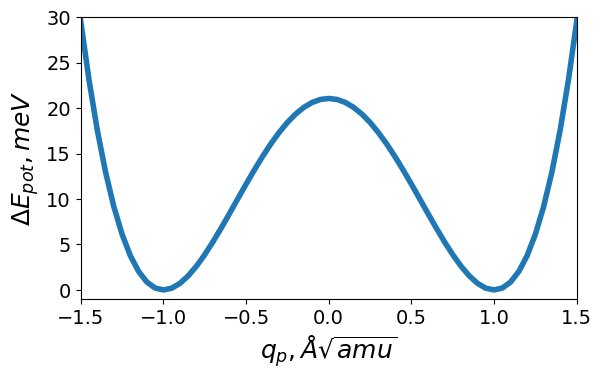

In [10]:
qLowLine, qHighLine, potLine = getLinePESQHighConst(qLow, qHigh, pot, qHighConst=0.0)
#potLine -= min(potLine)
# energy in meV
potLine *= 1000
plt.plot(qLowLine, potLine, linewidth=4.0)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.0, 30.0])
plt.gca().set_aspect(0.055)
plt.xlabel(r'$q_{p}, \AA \sqrt{amu}$', fontsize=18)
plt.ylabel(r'$\Delta E_{pot}, meV$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('BTO_double_well.png', format='png', dpi=1200, transparent=True, bbox_inches='tight', pad_inches=0)

In [11]:
from scipy import interpolate
f = interpolate.interp2d(qLow, qHigh, pot, kind='quintic', bounds_error=True)

C:\Users\p.zhilyaev\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=5,5 nx,ny=77,60 m=7380 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [12]:
def getLinePESQHighConstSpline(qLow, qHigh, potInterpolation, qHighConst):
    """
    Obtain line with Q_high = const from PES
    """
    qLowLine = []
    qHighLine = []
    potLine = []
    for ql, qh in zip(qLow, qHigh):
        if np.abs(qh - qHighConst) < 1E-10:
            qLowLine.append(ql)
            qHighLine.append(qh)
            potLine.append(potInterpolation(ql, qh))
    return np.asarray(qLowLine), np.asarray(qHighLine), np.asarray(potLine)

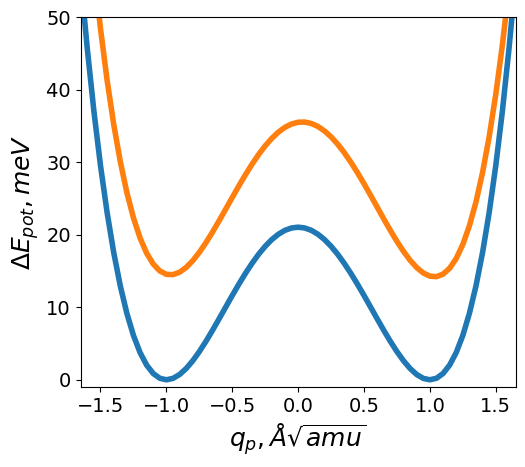

In [36]:
qLowLine, qHighLine, potLine = getLinePESQHighConst(qLow, qHigh, pot, qHighConst=0.0)
potLine -= min(potLine)
# energy in meV
potLine *= 1000
#plt.plot(qLowLine, potLine, linewidth=4.0)
qLowLine, qHighLine, potLine = getLinePESQHighConstSpline(qLow, qHigh, f, qHighConst=0.0)
potLine *= 1000
plt.plot(qLowLine, potLine, linewidth=4.0)
qLowLine, qHighLine, potLine = getLinePESQHighConstSpline(qLow, qHigh, f, qHighConst=0.5)
potLine *= 1000
plt.plot(qLowLine, potLine, linewidth=4.0)
plt.xlim([-1.65, 1.65])
plt.ylim([-1.0, 50.0])
plt.gca().set_aspect(0.055)
plt.xlabel(r'$q_{p}, \AA \sqrt{amu}$', fontsize=18)
plt.ylabel(r'$\Delta E_{pot}, meV$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('BTO_double_well.png', format='png', dpi=1200, transparent=True, bbox_inches='tight', pad_inches=0)

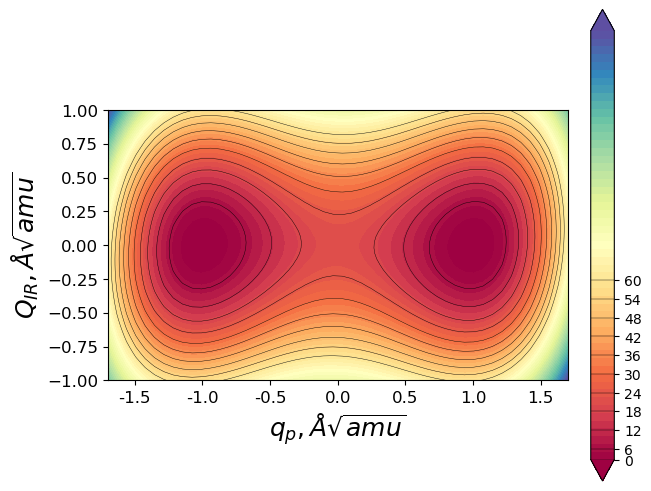

In [24]:
x = np.linspace(-1.7, 1.7, 50)
y = np.linspace(-1.0, 1.0, 50)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(X[i, j], Y[i, j])
fig, ax = plt.subplots(constrained_layout=True)


# Energy in meV
Z *= 1000

cs0 = ax.contourf(X, Y, Z, 60,
                   cmap = 'Spectral',
                   extend='both')

levels = np.linspace(0.0, 60, 11, endpoint=True)
cs1 = ax.contour(X, Y, Z, 
                 levels=levels, 
                 colors='black', 
                 linewidths=(0.3,))

# Add the contour line levels to the colorbar
cbar = fig.colorbar(cs0)
cbar.add_lines(cs1)
cbar.set_ticks(levels)

#ax.set_title('PTO PES: VASP Interpolated By Splines')
ax.set_xlabel(r'$q_{p}, \AA \sqrt{amu}$', fontsize=18)
ax.set_ylabel(r'$Q_{IR}, \AA \sqrt{amu}$', fontsize=18)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xticks = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
fig.savefig('BTO_PES_2D.png', format='png', dpi=1200, transparent=True, bbox_inches='tight', pad_inches=0)
ax.set_aspect('equal', adjustable='box')

In [40]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
save_object(f, 'pes_spline_interpolation')

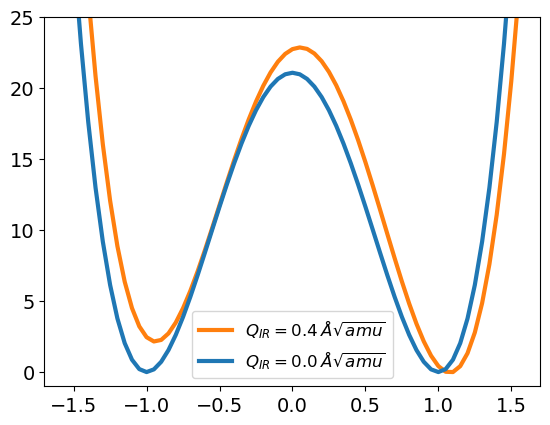

In [39]:
qLowLine, qHighLine, potLine = getLinePESQHighConst(qLow, qHigh, pot, qHighConst=1.0)
potLine -= min(potLine)
potLine *= 1000 # energy in meV
plt.plot(qLowLine, potLine, linewidth=3.0, label=r'$Q_{IR} = 0.4 \: \AA \sqrt{amu}$', color='#ff7f0e')

# qLowLine, qHighLine, potLine = getLinePESQHighConst(qLow, qHigh, pot, qHighConst=0.2)
# potLine -= min(potLine)
# plt.plot(qLowLine, potLine, linewidth=4.0, label='0.2 eV', color='#2ca02c')

qLowLine, qHighLine, potLine = getLinePESQHighConst(qLow, qHigh, pot, qHighConst=0.0)
potLine -= min(potLine)
potLine *= 1000 # energy in meV
plt.plot(qLowLine, potLine, linewidth=3.0, label=r'$Q_{IR} = 0.0 \: \AA \sqrt{amu}$', color='#1f77b4')

plt.xlim([-1.7, 1.7])
plt.ylim([-1, 25])
#plt.xlabel(r'$q_{p}, \AA \sqrt{amu}$', fontsize=18)
#plt.ylabel(r'$\Delta E_{pot}, eV$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=12, frameon=True)

#plt.show()
plt.savefig('BTO_double_well_at_different_QIR.png', format='png', dpi=1200, transparent=True, bbox_inches='tight', pad_inches=0)

In [9]:
def getInterpolatedPES(qLow, qHigh, coefficientsOfInterpolation):
    
    omegaLow = coefficientsOfInterpolation['omegaLow']
    a3 = coefficientsOfInterpolation['a3']
    a4 = coefficientsOfInterpolation['a4']
    a5 = coefficientsOfInterpolation['a5']
    a6 = coefficientsOfInterpolation['a6']
    
    res = 0.5 * omegaLow**2 * qLow**2
    res += 1.0 / 3.0 * a3 * qLow**3
    res += 1.0 / 4.0 * a4 * qLow**4
    res += 1.0 / 5.0 * a5 * qLow**5
    res += 1.0 / 6.0 * a6 * qLow**6
    
    omegaHigh = coefficientsOfInterpolation['omegaHigh']
    b3 = coefficientsOfInterpolation['b3']
    b4 = coefficientsOfInterpolation['b4']
    b5 = coefficientsOfInterpolation['b5']
    b6 = coefficientsOfInterpolation['b6']
    
    res += 0.5 * omegaHigh**2 * qHigh**2
    res += 1.0 / 3.0 * b3 * qHigh**3
    res += 1.0 / 4.0 * b4 * qHigh**4
    res += 1.0 / 5.0 * b5 * qHigh**5
    res += 1.0 / 6.0 * b6 * qHigh**6
    
    g = coefficientsOfInterpolation['g']
    h = coefficientsOfInterpolation['h']
    i = coefficientsOfInterpolation['i']
    j = coefficientsOfInterpolation['j']
    k = coefficientsOfInterpolation['k']
    l = coefficientsOfInterpolation['l']
    
    res += g * qLow * qHigh**2
    res += h * qLow**2 * qHigh
    res += i * qLow**3 * qHigh
    res += j * qLow * qHigh**3 
    res += k * qLow**2 * qHigh**3
    res += l * qLow * qHigh**4
    
    return res

In [12]:
coeffDictSUBEDI = {}

coeffDictSUBEDI['omegaLow'] = OMEGA_LOW
coeffDictSUBEDI['a3'] = 21.80 / 1000.0
coeffDictSUBEDI['a4'] = 1.89 / 1000.0
coeffDictSUBEDI['a5'] = 0.0
coeffDictSUBEDI['a6'] = 0.0

coeffDictSUBEDI['omegaHigh'] = OMEGA_HIGH
coeffDictSUBEDI['b3'] = 1567.65 / 1000.0
coeffDictSUBEDI['b4'] = 631.80 / 1000.0
coeffDictSUBEDI['b5'] = 0
coeffDictSUBEDI['b6'] = 0

coeffDictSUBEDI['g'] = 70.32 / 1000.0
coeffDictSUBEDI['h'] = -12.40 / 1000.0
coeffDictSUBEDI['i'] = -0.79 / 1000.0
coeffDictSUBEDI['j'] = 52.14 / 1000.0
coeffDictSUBEDI['k'] = 2.29 / 1000.0
coeffDictSUBEDI['l'] = 7.61 / 1000.0

In [13]:
def subedi(qLow, qHigh):
    return getInterpolatedPES(qLow, qHigh, coeffDictSUBEDI)

In [14]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
save_object(subedi, 'pes_tailor_interpolation')

In [60]:
qLow, qHigh, pot = readPES(filename='energy.txt')
pot -= min(pot)

In [61]:
from scipy import interpolate
f = interpolate.interp2d(qLow, qHigh, pot, kind='cubic', bounds_error=True)

In [62]:
 def getSplineInetpolation(qlow, qhigh, interpolatingFunc):
        return [interpolatingFunc(x1, x2) for x1, x2 in zip(qlow, qhigh)]

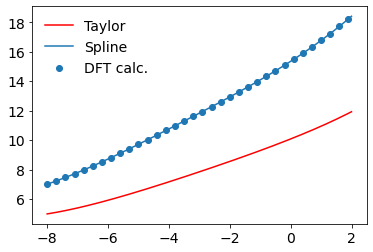

In [64]:
qHighConst = 2.0
qLowList, qHighList, potentialList = getLinePESQHighConst(qLow, qHigh, pot, qHighConst)

plt.scatter(qLowList[::3], potentialList[::3], label='DFT calc.')

x = np.linspace(-8, 2, 1000)

y = getInterpolatedPES(x, qHighConst * np.ones(len(x)), coeffDictSUBEDI)
plt.plot(x, y, color='red', label='Taylor')

yspline = getSplineInetpolation(x, qHighConst * np.ones(len(x)), f)
plt.plot(x, yspline, label='Spline')

plt.legend(fontsize=14, frameon=False)
#plt.title('PES slice at Qhigh = {}'.format(qHighConst))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Q_HIGH_CONST_2.png', format='png', dpi=800)
#plt.show()

In [ ]:
qLowList, qHighList, potentialList = getQLowQHighPot(filename='energy.txt')

qLowConst = -8.0
m = min(potentialList)
qLowList, qHighList, potentialList = getLinePESQLowConst(qLowList, 
                                               qHighList, 
                                               potentialList,
                                               qLowConst)
potentialList -= m
plt.plot(qHighList, potentialList, label='VASP calc.')

x = np.linspace(-3, 3, 1000)
y = getInterpolatedPES(qLowConst * np.ones(len(x)), x, coeffDictSUBEDI)
plt.plot(x, y, label='SUBEDI interp.')
plt.legend()
plt.title('PES slice at Qlow = {}'.format(qLowConst))
plt.show()

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
       2.25 , 2.375, 2.5  ])

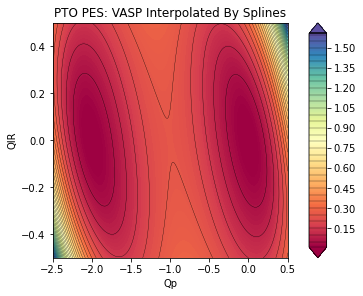

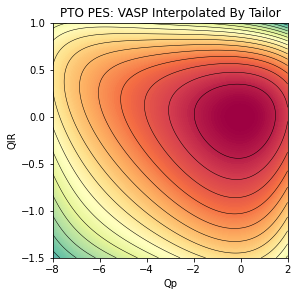

In [102]:
x = np.linspace(-8.0, 2.0, 300)
y = np.linspace(-1.5, 1.0, 300)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = getInterpolatedPES(X[i, j], Y[i, j], coeffDictSUBEDI)
        
fig, ax = plt.subplots(constrained_layout=True)

# сs2 = ax.contourf(X, Y, Z, cs0.levels,
#                    cmap = 'Spectral',
#                    extend='both')

сs2 = ax.contourf(X, Y, Z, cs0.levels,
                   cmap = 'Spectral',
                   extend='both')

cs3 = ax.contour(X, Y, Z, 
                 levels=cs1.levels, 
                 colors='black', 
                 linewidths=(0.5,))

#cbar = fig.colorbar(сs2)
# Add the contour line levels to the colorbar
#cbar.add_lines(cs3)

ax.set_title('PTO PES: VASP Interpolated By Tailor')
ax.set_xlabel('Qp')
ax.set_ylabel('QIR')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#ax.set_aspect('equal', adjustable='box')

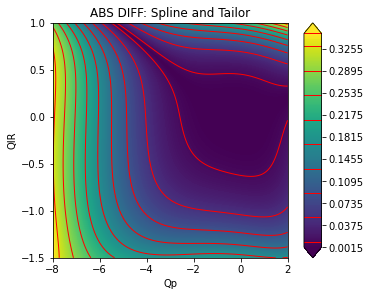

In [115]:
x = np.linspace(-8.0, 2.0, 300)
y = np.linspace(-1.5, 1.0, 300)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = np.abs(getInterpolatedPES(X[i, j], Y[i, j], coeffDictSUBEDI) - f(X[i, j], Y[i, j]))

fig, ax = plt.subplots(constrained_layout=True)

сs0 = ax.contourf(X, Y, Z, 256,
                   cmap = 'viridis',
                   extend='both')

cs1 = ax.contour(X, Y, Z, 
                 levels=cs0.levels[::4], 
                 colors='r', 
                 linewidths=(1.0,))

# Add the contour line levels to the colorbar
cbar = fig.colorbar(сs0)
cbar.add_lines(cs1)
#cbar.set_ticks(levels[::2])

ax.set_title('ABS DIFF: Spline and Tailor')
ax.set_xlabel('Qp')
ax.set_ylabel('QIR')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

C:\Users\Maria\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=52,66 m=4938 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


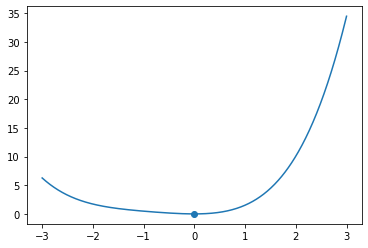

In [24]:
qLowConst = 0.0
qLowList, qHighList, potentialList = getLinePESQLowConst(qLowList, 
                                               qHighList, 
                                               potentialList,
                                               qLowConst)

plt.scatter(qHighList, potentialList)



In [5]:
def getLinRegCoeff(X, y):
    """
    """
    reg = linear_model.LinearRegression()
    reg.fit(X, y)
    print('R^2 score = ', reg.score(X, y))
    return reg.coef_

In [6]:
def getInterpolatedLinePES(x, c3, c4, c5, c6, omega):
    res = 0.5 * omega**2 * x**2
    res += 1.0 / 3.0 * c3 * x**3
    res += 1.0 / 4.0 * c4 * x**4
    res += 1.0 / 5.0 * c5 * x**5
    res += 1.0 / 6.0 * c6 * x**6
    return res

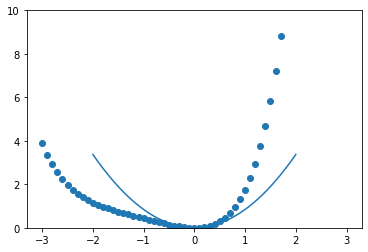

In [10]:
qLowList, qHighList, potentialList = getQLowQHighPot(filename='energy.txt')
qLowList, qHighList, potentialList = getLinePESQLowConst(qLowList, 
                                               qHighList, 
                                               potentialList,
                                               qLowConst = 0.0)
plt.scatter(qHighList, potentialList)
x = np.linspace(-2, 2, 1000)
y = 0.5 * omegaHigh**2 * x**2
plt.plot(x, y)
plt.ylim(0, 10)
plt.show()

In [12]:
coeffDictEVA = {}

coeffDictEVA['omegaLow'] = omegaLow
coeffDictEVA['a3'] = 20.177 / 1000.0
coeffDictEVA['a4'] = 1.688 / 1000.0
coeffDictEVA['a5'] = 0.0
coeffDictEVA['a6'] = 0.0

coeffDictEVA['omegaHigh'] = omegaHigh
coeffDictEVA['b3'] = 2232.090 / 1000.0
coeffDictEVA['b4'] = 1168.257 / 1000.0
coeffDictEVA['b5'] = 0
coeffDictEVA['b6'] = 0

coeffDictEVA['g'] = 72.921 / 1000.0
coeffDictEVA['h'] = -14.714 / 1000.0
coeffDictEVA['i'] = -0.956 / 1000.0
coeffDictEVA['j'] = 72.177 / 1000.0
coeffDictEVA['k'] = 2.938 / 1000.0
coeffDictEVA['l'] = 15.874 / 1000.0

In [14]:
qLowList, qHighList, potentialList = getQLowQHighPot()

X = 1.0 / 3.0 * qLowList**3
X = X.reshape(-1, 1)
Xadd = 1.0 / 4.0 * qLowList**4
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))
Xadd = 1.0 / 5.0 * qLowList**5
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))
Xadd = 1.0 / 6.0 * qLowList**6
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))
y = potentialList - 0.5 * omegaLow**2 * qLowList**2

Xadd = 1.0 / 3.0 * qHighList**3
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))
Xadd = 1.0 / 4.0 * qHighList**4
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))
Xadd = 1.0 / 5.0 * qHighList**5
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))
Xadd = 1.0 / 6.0 * qHighList**6
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))


Xadd = qLowList * qHighList**2
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

Xadd = qLowList * qHighList**2
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

Xadd = qLowList * qHighList**2
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

Xadd = qLowList**2 * qHighList
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

Xadd = qLowList**3 * qHighList
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

Xadd = qLowList * qHighList**3
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

Xadd = qLowList**2 * qHighList**3
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

Xadd = qLowList * qHighList**4
Xadd = Xadd.reshape(-1, 1)
X = np.hstack((X, Xadd))

coeffDict = {}
coeffList = getLinRegCoeff(X, y)
coeffNames = ['a3', 'a4', 'a5', 'a6', 'b3', 'b4', 'b5', 'b6', 'g', 'h', 'i', 'j', 'k', 'l']
for coeff, name in zip(coeffList, coeffNames):
    coeffDict[name] = coeff  

coeffDict['omegaLow'] = omegaLow    
coeffDict['omegaHigh'] = omegaHigh

coeffDictMY = coeffDict

R^2 score =  0.9993641874205824


In [16]:
from scipy import interpolate
qLowList, qHighList, potentialList = getQLowQHighPot(filename='energy_QP_QIR.txt')
#qLowCoarseList, qHighCoarseList, potentialCoarseList = getQLowQHighPot()

qLowList = qLowList.tolist()
qHighList = qHighList.tolist()
potentialList = potentialList.tolist()

# for qLow, qHigh, pot in zip(qLowCoarseList, qHighCoarseList, potentialCoarseList):
#     qLowList.append(qLow)
#     qHighList.append(qHigh)
#     potentialList.append(pot)
    
qLowList = np.asarray(qLowList)
qHighList = np.asarray(qHighList)
potentialList = np.asarray(potentialList)
    
f = interpolate.interp2d(qLowList, qHighList, potentialList, kind='cubic', bounds_error=True)

C:\Users\Maria\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=52,66 m=4938 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [34]:
def getSplineInterpolatedPES(f, qLowList, qHighList):
    y = []
    for qLow, qHigh in zip(qLowList, qHighList):
        y.append(f(qLow, qHigh))
    return y

NameError: name 'getSplineInterpolatedPES' is not defined

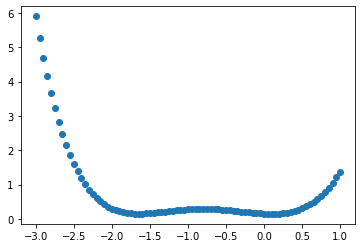

In [15]:
from scipy import interpolate
qLowList, qHighList, potentialList = getQLowQHighPot(filename='energy_QP_QIR.txt')
#qLowCoarseList, qHighCoarseList, potentialCoarseList = getQLowQHighPot()

#print(min(qLowList), max(qLowList))
#print(min(qHighList), max(qHighList))

# qLowList = qLowList.tolist()
# qHighList = qHighList.tolist()
# potentialList = potentialList.tolist()

# for qLow, qHigh, pot in zip(qLowCoarseList, qHighCoarseList, potentialCoarseList):
#     qLowList.append(qLow)
#     qHighList.append(qHigh)
#     potentialList.append(pot)
    
# qLowList = np.asarray(qLowList)
# qHighList = np.asarray(qHighList)
# potentialList = np.asarray(potentialList)



#qLowList, qHighList, potentialList = getQLowQHighPot()
qHighConst = -0.5
qLowList, qHighList, potentialList = getLinePESQHighConst(qLowList, 
                                               qHighList, 
                                               potentialList,
                                               qHighConst)

plt.scatter(qLowList, potentialList)

x = np.linspace(-3, 1, 1000)
#y = getInterpolatedPES(x, qHighConst * np.ones(len(x)), coeffDictEVA)
#plt.plot(x, y)

y =  getSplineInterpolatedPES(f, x, qHighConst * np.ones(len(x)))
plt.plot(x, y)

plt.show()

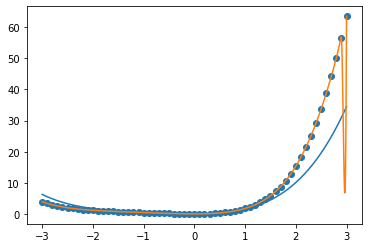

In [36]:
qLowList, qHighList, potentialList = getQLowQHighPot()
qLowConst = 0.0
qLowList, qHighList, potentialList = getLinePESQLowConst(qLowList, 
                                               qHighList, 
                                               potentialList,
                                               qLowConst)

plt.scatter(qHighList, potentialList)

x = np.linspace(-3, 3, 1000)
y = getInterpolatedPES(qLowConst * np.ones(len(x)), x, coeffDictSUBEDI)
plt.plot(x, y)

y =  getSplineInterpolatedPES(f, qLowConst * np.ones(len(x)), x)
plt.plot(x, y)

plt.show()

In [19]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
save_object(f, 'pes_spline_interpolation')

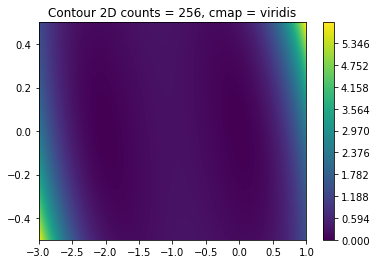

In [44]:
x = np.linspace(-3.0, 1.0, 300)
y = np.linspace(-0.5, 0.5, 300)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(X[i, j], Y[i, j])
        
plt.contourf(X, Y, Z, 1024)#, cmap = 'Spectral')
plt.title('Contour 2D counts = 256, cmap = viridis')
plt.colorbar()
plt.show()

In [2]:
import numpy as np

In [3]:
3.0 * 137 * 1.16 / 1.6 

297.97499999999997

In [4]:
8.85 * 9 * 4 / 2

159.29999999999998

In [5]:
np.sqrt(137)

11.704699910719626

In [6]:
0.2/11.7

0.017094017094017096

In [7]:
137*1.66*1.7/2/1.6

120.81687499999998

In [8]:
8.85*1.2**2 * 4 / 2

25.488